In [3]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.stem.porter import PorterStemmer
from collections import Counter
import warnings
from scipy.sparse import csr_matrix
import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split 

from keras.models import Sequential
from keras.layers import Dense,Dropout
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.layers.normalization import BatchNormalization
import pickle
from tqdm import tqdm
import os

Using TensorFlow backend.


In [4]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [5]:
path = "/content/drive/My Drive/database.sqlite"

con = sqlite3.connect(path)

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [0]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [7]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [8]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


In [0]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [10]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [0]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [12]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


1    307061
0     57110
Name: Score, dtype: int64

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews


In [13]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
I was really looking forward to these pods based on the reviews.  Starbucks is good, but I prefer bolder taste.... imagine my surprise when I ordered 2 boxes - both were expired! One expired back in 2005 for gosh sakes.  I admit that Amazon agreed to credit me for cost plus part of shipping, but geez, 2 years expired!!!  I'm hoping to find local San Diego area shoppe that carries pods so that I can try something different than starbucks.
Great ingredients although, chicken should have been 1st rather than chicken broth, the only thing I do not think belongs in it is Canola oil. Canola or rapeseed is not someting a do

In [14]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
I was really looking forward to these pods based on the reviews.  Starbucks is good, but I prefer bolder taste.... imagine my surprise when I ordered 2 boxes - both were expired! One expired back in 2005 for gosh sakes.  I admit that Amazon agreed to credit me for cost plus part of shipping, but geez, 2 years expired!!!  I'm hoping to find local San Diego area shoppe that carries pods so that I can try something different than starbucks.
Great ingredients although, chicken should have been 1st rather than chicken broth, the only thing I do not think belongs in it is Canola oil. Canola or rapeseed is not someting a do

In [0]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [0]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [17]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
final = final.sample(n=100000)
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 100000/100000 [00:40<00:00, 2463.82it/s]


In [18]:
# Please write all the code with proper documentation
#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

label = final['Score']
final['preprocessed_reviews'] = preprocessed_reviews

X_train, X_test, y_train, y_test = train_test_split(final, label, test_size=0.3, random_state=0)

type(final)
print(final.head(3))


            Id  ...                               preprocessed_reviews
52874    57427  ...  truly surprised green healthy plants appeared ...
475864  514601  ...  swedish vanilla almond bread machine mix wonde...
174994  189782  ...  product works well especially frying foods not...

[3 rows x 11 columns]


In [19]:
print(len(X_train['preprocessed_reviews']))
X_train_rev = X_train['preprocessed_reviews'].values
print(X_train_rev.shape)

words_list = []
vocab = {}
for rev in X_train_rev:
  words_list.append(rev.split())

print(len(words_list))

for sent in words_list:
  for word in sent:
    if(word in vocab):
      vocab[word] += 1
    else:
      vocab[word] = 1

print(vocab)
print("Number of unique words in train date set = " ,len(vocab))

70000
(70000,)
70000
{'probably': 2191, 'best': 9668, 'bloody': 82, 'mary': 82, 'mix': 5401, 'ever': 4262, 'first': 7018, 'encountered': 84, 'product': 18850, 'hotel': 84, 'bar': 2168, 'wife': 1156, 'looking': 3180, 'liked': 1765, 'proved': 37, 'perfect': 4055, 'choice': 1135, 'pleased': 1286, 'find': 9346, 'available': 2231, 'amazon': 11249, 'bottle': 2443, 'cases': 358, 'prime': 478, 'shipping': 3353, 'no': 12637, 'less': 3973, 'great': 20753, 'bargain': 255, 'not': 71943, 'go': 5378, 'day': 5377, 'without': 4344, 'chai': 809, 'simply': 1071, 'loves': 3812, 'used': 7025, 'get': 12388, 'sam': 172, 'club': 225, 'longer': 1577, 'least': 1858, 'found': 6698, 'another': 3118, 'place': 1263, 'purchase': 2966, 'nice': 5018, 'mild': 1019, 'taste': 19741, 'burned': 138, 'bitter': 1861, 'like': 29296, 'dark': 2392, 'roasts': 171, 'caffeine': 1141, 'free': 6151, 'cups': 2550, 'enjoyed': 1298, 'flavors': 4318, 'variety': 1879, 'pack': 2644, 'definately': 197, 'buy': 9354, 'many': 5076, 'options'

In [20]:
sorted_vocab = sorted(vocab, key = vocab.get, reverse=True)
#We will select the top 10k words
top_words = 10000
sorted_vocab = sorted_vocab[:10000]
print(sorted_vocab)

def convert_vec(review_corpus):
  # conv_vec = np.array
  conv_vec = []
  i=0
  for sent in tqdm(review_corpus):
    sent_arr = []
    for word in sent:
      if(word in sorted_vocab):
        sent_arr.append(sorted_vocab.index(word))
        
    conv_vec.append(sent_arr)
    i+=1
  return conv_vec

train_vec = convert_vec(words_list)
print(train_vec[:5])
print(len(train_vec))

  0%|          | 59/70000 [00:00<01:59, 585.39it/s]

['not', 'like', 'good', 'great', 'one', 'taste', 'product', 'would', 'flavor', 'coffee', 'tea', 'love', 'no', 'get', 'food', 'really', 'amazon', 'use', 'much', 'also', 'time', 'best', 'little', 'buy', 'find', 'price', 'tried', 'make', 'well', 'even', 'try', 'better', 'chocolate', 'eat', 'sugar', 'used', 'first', 'could', 'water', 'found', 'made', 'sweet', 'free', 'dog', 'bought', 'bag', 'box', 'cup', 'store', 'drink', 'way', 'tastes', 'delicious', 'order', 'two', 'think', 'mix', 'go', 'day', 'since', 'recommend', 'still', 'many', 'know', 'nice', 'bit', 'favorite', 'add', 'never', 'got', 'years', 'hot', 'give', 'stuff', 'want', 'milk', 'makes', 'every', 'always', 'brand', 'without', 'flavors', 'something', 'quality', 'lot', 'ever', 'right', 'ordered', 'say', 'easy', 'perfect', 'organic', 'back', 'healthy', 'fresh', 'less', 'enough', 'products', 'different', 'oil', 'need', 'loves', 'small', 'keep', 'using', 'long', 'put', 'sauce', 'ingredients', 'whole', 'hard', 'enjoy', 'sure', 'old', '

100%|██████████| 70000/70000 [02:04<00:00, 562.37it/s]

[[227, 21, 3385, 3386, 56, 85, 36, 3334, 6, 3335, 230, 424, 138, 3385, 3386, 56, 295, 5363, 90, 436, 394, 24, 224, 16, 204, 1214, 16, 973, 125, 12, 95, 3, 56, 3, 1565], [424, 0, 57, 58, 80, 618, 466, 101, 35, 13, 2105, 1725, 12, 327, 273, 39, 141, 397, 160], [64, 500, 5, 0, 2423, 272, 5, 1, 210, 2117], [431, 42, 191, 387, 81, 271, 183, 1895, 23], [62, 1471, 285, 4668, 3, 126, 224, 165, 42, 4, 633, 93, 911, 1176, 151, 51, 2, 84, 206, 8, 186, 0, 673, 39, 22, 934, 4124, 75, 433, 1069, 175, 185, 4, 93, 3, 1741, 29, 31, 837, 75, 197, 285, 7, 244, 2, 180, 197]]
70000


In [21]:
X_test_rev = X_test['preprocessed_reviews'].values
print(X_test_rev.shape)
test_words_list = []

for rev in X_test_rev:
  test_words_list.append(rev.split())

print(len(test_words_list))

test_vec = convert_vec(test_words_list)
print(train_vec[:5])
# Xtest_vec = np.asarray(test_vec)
print(len(test_vec))

  0%|          | 52/30000 [00:00<00:58, 511.76it/s]

(30000,)
30000


100%|██████████| 30000/30000 [00:54<00:00, 551.30it/s]

[[227, 21, 3385, 3386, 56, 85, 36, 3334, 6, 3335, 230, 424, 138, 3385, 3386, 56, 295, 5363, 90, 436, 394, 24, 224, 16, 204, 1214, 16, 973, 125, 12, 95, 3, 56, 3, 1565], [424, 0, 57, 58, 80, 618, 466, 101, 35, 13, 2105, 1725, 12, 327, 273, 39, 141, 397, 160], [64, 500, 5, 0, 2423, 272, 5, 1, 210, 2117], [431, 42, 191, 387, 81, 271, 183, 1895, 23], [62, 1471, 285, 4668, 3, 126, 224, 165, 42, 4, 633, 93, 911, 1176, 151, 51, 2, 84, 206, 8, 186, 0, 673, 39, 22, 934, 4124, 75, 433, 1069, 175, 185, 4, 93, 3, 1741, 29, 31, 837, 75, 197, 285, 7, 244, 2, 180, 197]]
30000


In [22]:
#find max review length in the train corpus
max_len = 0
for sent in train_vec:
  max_len = max(max_len,len(sent))

print("The maximum length of review in our train corpus is: ",max_len)

max_len = 0
for sent in test_vec:
  max_len = max(max_len,len(sent))

print("The maximum length of review in our test corpus is: ",max_len)

The maximum length of review in our train corpus is:  975
The maximum length of review in our test corpus is:  999


In [23]:
# truncate and/or pad input sequences to a max length of 600
max_review_length = 600
X_train = sequence.pad_sequences(train_vec, maxlen=max_review_length)
X_test = sequence.pad_sequences(test_vec, maxlen=max_review_length)

print(X_train.shape)
print(X_train[1])
print(X_test.shape)
print(X_test[1])

(70000, 600)
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import time
# https://gist.github.com/greydanus/f6eee59eaf1d90fcb3b534a25362cea4
# https://stackoverflow.com/a/14434334
# this function is used to update the plots for each epoch and error
def plt_dynamic(x, vy, ty, ax, colors=['b']):
    ax.plot(x, vy, 'b', label="Validation Loss")
    ax.plot(x, ty, 'r', label="Train Loss")
    plt.legend()
    plt.grid()
    # fig.canvas.draw()
    plt.show()

##Architecture 1: Embedding-->LSTM-->SIGMOID##


In [49]:
# create the model
embedding_vecor_length = 32
model = Sequential()
model.add(Embedding(top_words+1, embedding_vecor_length, input_length=max_review_length))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
#Refer: https://datascience.stackexchange.com/questions/10615/number-of-parameters-in-an-lstm-model

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 600, 32)           320032    
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 373,333
Trainable params: 373,333
Non-trainable params: 0
_________________________________________________________________
None


Train on 70000 samples, validate on 30000 samples
Epoch 1/10
70000/70000 [==============================] - 551s 8ms/step - loss: 0.2620 - accuracy: 0.8985 - val_loss: 0.2065 - val_accuracy: 0.9191
Epoch 2/10
70000/70000 [==============================] - 557s 8ms/step - loss: 0.1678 - accuracy: 0.9349 - val_loss: 0.1936 - val_accuracy: 0.9208
Epoch 3/10
70000/70000 [==============================] - 555s 8ms/step - loss: 0.1458 - accuracy: 0.9439 - val_loss: 0.2022 - val_accuracy: 0.9161
Epoch 4/10
70000/70000 [==============================] - 549s 8ms/step - loss: 0.1267 - accuracy: 0.9525 - val_loss: 0.2136 - val_accuracy: 0.9152
Epoch 5/10
70000/70000 [==============================] - 551s 8ms/step - loss: 0.1124 - accuracy: 0.9586 - val_loss: 0.2201 - val_accuracy: 0.9212
Epoch 6/10
70000/70000 [==============================] - 553s 8ms/step - loss: 0.0998 - accuracy: 0.9642 - val_loss: 0.2395 - val_accuracy: 0.9193
Epoch 7/10
70000/70000 [==============================] - 549s

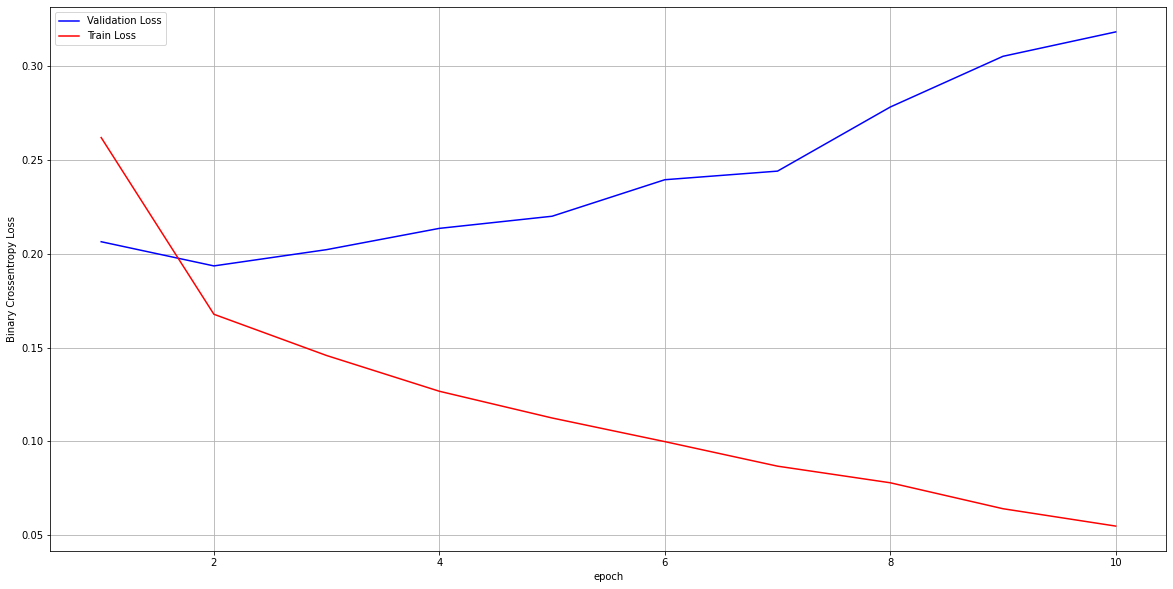

In [50]:
batch_size = 128
epochs = 10

history = model.fit(X_train, y_train, nb_epoch=epochs, batch_size=batch_size,validation_data=(X_test,y_test))
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

print('Test loss:', scores[0])
print('Test accuracy:', scores[1])


fig,ax = plt.subplots(1,1,figsize=(20,10))
ax.set_xlabel('epoch') ; ax.set_ylabel('Binary Crossentropy Loss')

# list of epoch numbers
x = list(range(1,epochs+1))

vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, ax)

##Architecture 2: Embedding-->LSTM(100)-->LSTM(50)-->BatchNorm--> SIGMOID

In [25]:
# create the model
embedding_vecor_length = 32
model = Sequential()
model.add(Embedding(top_words+1, embedding_vecor_length, input_length=max_review_length))
model.add(LSTM(50,return_sequences=True))
model.add(Dropout(0.25))
model.add(LSTM(100))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
#Refer: https://datascience.stackexchange.com/questions/10615/number-of-parameters-in-an-lstm-model

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 600, 32)           320032    
_________________________________________________________________
lstm_1 (LSTM)                (None, 600, 50)           16600     
_________________________________________________________________
dropout_1 (Dropout)          (None, 600, 50)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               60400     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 100)               400       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                

Train on 70000 samples, validate on 30000 samples
Epoch 1/10
70000/70000 [==============================] - 1608s 23ms/step - loss: 0.2776 - accuracy: 0.8881 - val_loss: 0.2652 - val_accuracy: 0.8806
Epoch 2/10
70000/70000 [==============================] - 1597s 23ms/step - loss: 0.1789 - accuracy: 0.9303 - val_loss: 0.4339 - val_accuracy: 0.8283
Epoch 3/10
70000/70000 [==============================] - 1590s 23ms/step - loss: 0.1453 - accuracy: 0.9445 - val_loss: 0.2343 - val_accuracy: 0.9161
Epoch 4/10
70000/70000 [==============================] - 1586s 23ms/step - loss: 0.1151 - accuracy: 0.9571 - val_loss: 0.2862 - val_accuracy: 0.9155
Epoch 5/10
70000/70000 [==============================] - 1596s 23ms/step - loss: 0.0937 - accuracy: 0.9652 - val_loss: 0.2939 - val_accuracy: 0.9052
Epoch 6/10
70000/70000 [==============================] - 1601s 23ms/step - loss: 0.0755 - accuracy: 0.9727 - val_loss: 0.3228 - val_accuracy: 0.9069
Epoch 7/10
70000/70000 [==========================

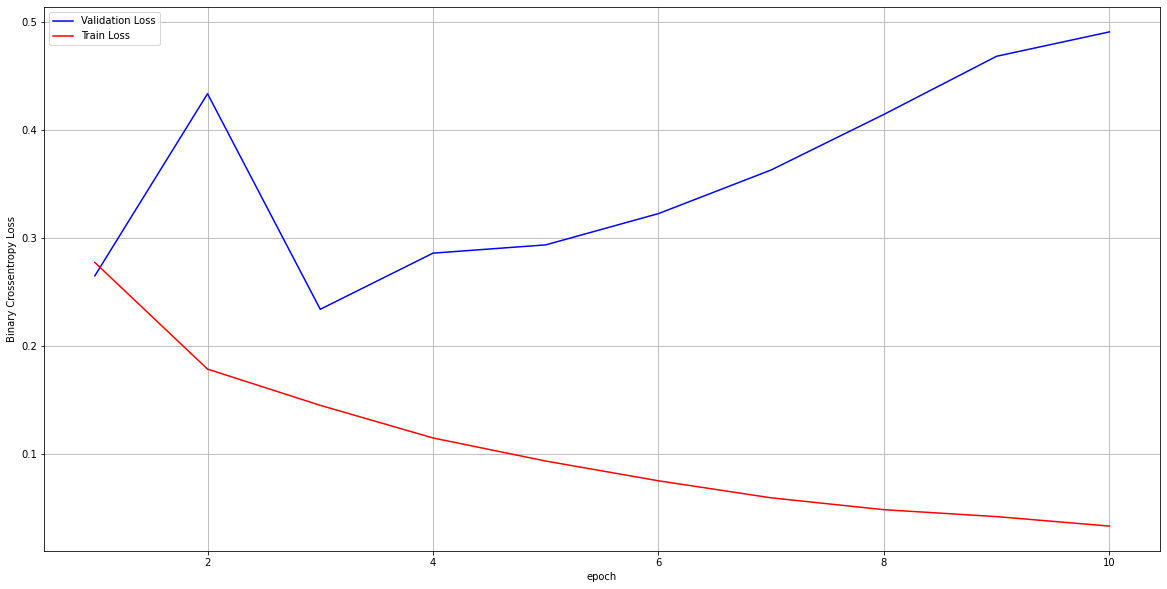

In [26]:
batch_size = 128
epochs = 10

history = model.fit(X_train, y_train, nb_epoch=epochs, batch_size=batch_size,validation_data=(X_test,y_test))
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

fig,ax = plt.subplots(1,1,figsize=(20,10))
ax.set_xlabel('epoch') ; ax.set_ylabel('Binary Crossentropy Loss')

# list of epoch numbers
x = list(range(1,epochs+1))

vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, ax)

#CONCLUSION: #
  1. LSTM based models was performed on the AFF dataset using single and double layer architectures.
  2. The train and test errors were plotted for the same.
  3. Single layer LSTM had a better CV accuracy than double layer LSTM.

In [27]:
from prettytable import PrettyTable
x = PrettyTable(["Number of Layers", "Validation Accuracy","LSTM Cells", "Dropout" ])
x.add_row([1,91.03,100,0 ])
x.add_row([2,90.63,'I->50, II-->100 ',1 ])

print(x)


+------------------+---------------------+------------------+---------+
| Number of Layers | Validation Accuracy |    LSTM Cells    | Dropout |
+------------------+---------------------+------------------+---------+
|        1         |        91.03        |       100        |    0    |
|        2         |        90.63        | I->50, II-->100  |    1    |
+------------------+---------------------+------------------+---------+
